# Preprocesamiento y exploración de datos

## Inicialización

In [ ]:
# Importar librerías
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

from sklearn.neighbors import NearestNeighbors

## Carga de datos

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

In [ ]:
# Renombrar las columnas para que el código se vea más coherente con su estilo.
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
884,1,38.0,36500.0,2,0
3987,1,30.0,14400.0,2,0
67,1,37.0,29600.0,2,0
199,1,21.0,25100.0,0,0
3576,0,26.0,39300.0,3,0
1694,1,33.0,54400.0,0,0
4637,0,41.0,29000.0,2,0
2035,1,21.0,59200.0,1,0
2324,0,19.0,35200.0,0,0
3712,1,23.0,49600.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [ ]:
# Cambiar el tipo de edad (de float a int)
df['age'] = df['age'].astype(int)

In [ ]:
# Comprobar que la conversión se haya realizado con éxito
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [ ]:
# Estadísticas descriptivas de los datos
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


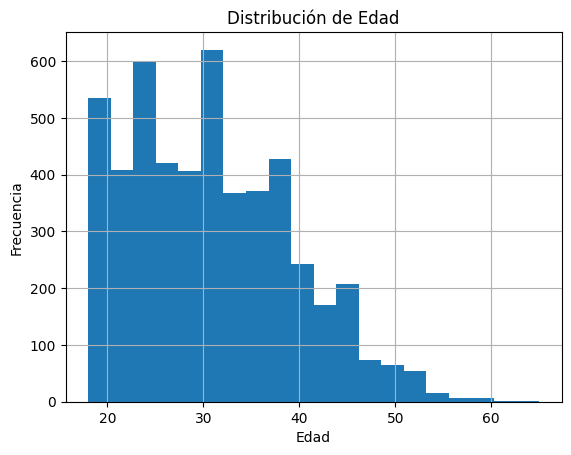

In [ ]:
# Ver la distribución de la edad
import matplotlib.pyplot as plt

df["age"].hist(bins=20)
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.title("Distribución de Edad")
plt.show()

<AxesSubplot:>

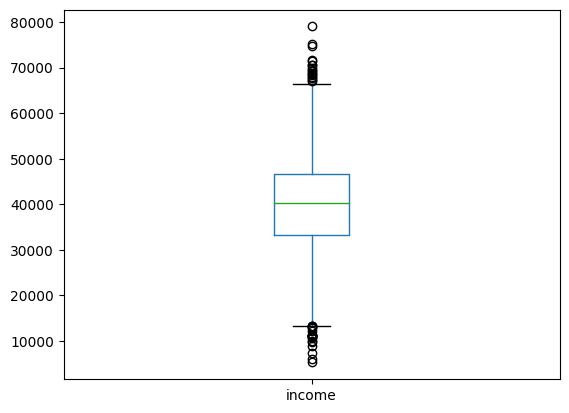

In [ ]:
# Boxplot de los ingresos
df["income"].plot(kind="box")

In [12]:
df["insurance_benefits"].value_counts().sort_index()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

En general, todo se ve en orden:
1. Columna gender: La media refleja que hay una distribución de los datos muy equitativa, de casi el 50%.
2. Columna edad: Como es lógico, la edad mínima es 18, lo cual quiere decir que los contratantes titulares deben ser mayores de edad para contratar un seguro. La media es similar a la mediana, lo cual indica que la distribución es más o menos simétrica.
3. Columna income: Esta tiene ciertos Outliers para ambos lados, pero no parecen extraños: hay algunas personas que seguramente están desempleadas, mientras que hay ejecutivos que tienen ingresos muy altos. La mayoría de las personas se encuentran en el Rango Intercuartil.
4. Columna family_members: La media es similar a la mediana. 3/4 de los asegurados tienen 2 familiares o menos. Hay algunos casos extremos de familias de hasta 6 personas. 
5. Columna insurance_benefits: El 75% de los asegurados muestra 0 beneficios, lo cual confirma que la mayoría de la gente no tiene beneficios. Sin embargo, hay algunos casos de múltiples beneficios. 

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

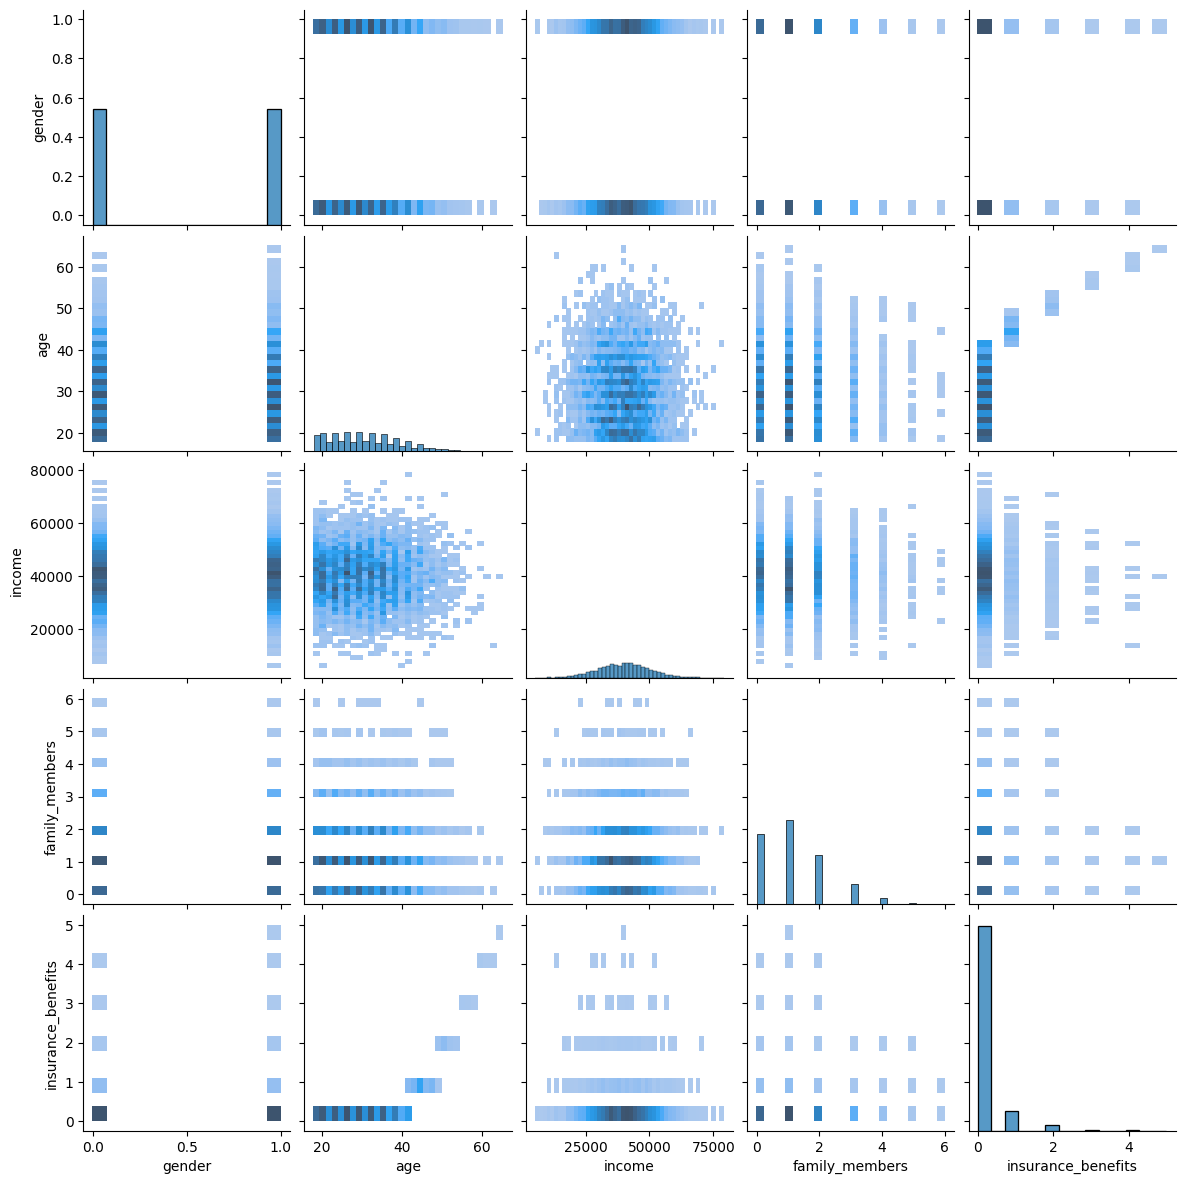

In [13]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

In [ ]:
# Establecer las features
feature_names = ['gender', 'age', 'income', 'family_members']  

In [ ]:
# Función para calcular los k vecinos más cercanos
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos para un objeto dado.

    :param df: DataFrame de pandas con los datos.
    :param n: Índice del objeto para el cual se buscan los vecinos más cercanos.
    :param k: Número de vecinos más cercanos a devolver.
    :param metric: Nombre de la métrica de distancia ('euclidean' o 'manhattan').
    :param scale: Booleano, si True, se escalan los datos con MaxAbsScaler.
    :return: DataFrame con los vecinos más cercanos y sus distancias.
    """
    
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [ ]:
# Escalar datos
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
530,1.0,0.553846,0.268354,0.166667,0
1437,0.0,0.384615,0.451899,0.166667,0
1720,0.0,0.369231,0.510127,0.166667,0
4711,0.0,0.384615,0.410127,0.000000,0
3336,1.0,0.369231,0.462025,0.500000,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
# Datos sin escalar con métrica = euclidean
get_knn(df, n=0, k=4, metric='euclidean')

,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.000000
2022,1,41,49600.0,0,0,1.000000
1225,0,42,49600.0,0,1,1.732051
4031,1,44,49600.0,2,1,3.162278


In [19]:
# Datos sin escalar con métrica = manhattan
get_knn(df, n=0, k=4, metric='manhattan')

,gender,age,income,family_members,insurance_benefits,distance
0,1,41,49600.0,1,0,0.0
2022,1,41,49600.0,0,0,1.0
1225,0,42,49600.0,0,1,3.0
4031,1,44,49600.0,2,1,4.0


In [20]:
# Datos escalados con métrica = euclidean
get_knn(df_scaled, n=0, k=4, metric='euclidean')

,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.017754
4869,1.0,0.646154,0.637975,0.166667,1,0.018418


In [21]:
# Datos escalados con métrica = manhattan
get_knn(df_scaled, n=0, k=4, metric='manhattan')

,gender,age,income,family_members,insurance_benefits,distance
0,1.0,0.630769,0.627848,0.166667,0,0.000000
2689,1.0,0.630769,0.634177,0.166667,0,0.006329
133,1.0,0.615385,0.636709,0.166667,0,0.024245
4869,1.0,0.646154,0.637975,0.166667,1,0.025511


**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí, afecta negativamente al funcionamiento del modelo. Esto se debe a que ciertas características que tengan mayor diferencia respecto a las otras y eso hace que tengan un mayor peso, provocando que se encuentre a los vecinos más cercanos de forma inadecuada. Como, por ejemplo, en este caso, después de escalar, se encontraron vecinos más cercanos diferentes a los que se habían encontrado sin escalar. 

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Son similares. Como es de esperarse, la distancia es ligeramente mayor cuando se usa Manhattan. Manhattan es más adecuado cuando no se permiten mediciones diagonales, como en búsqueda de rutas o valores atípicos, ya que es menos sensible a los extremos. Asimismo, la distancia Euclidiana se puede usar si no hay problema respecto a las diagonales.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?


La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

In [22]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits']>0).astype(int)

In [23]:
# comprueba el desequilibrio de clases con value_counts()
df['insurance_benefits_received'].value_counts() 

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

In [24]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# si tienes algún problema con la siguiente línea, reinicia el kernel y ejecuta el cuaderno de nuevo    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [25]:
# generar la salida de un modelo aleatorio
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [26]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



Matriz de confusión:
1. P = 0: El modelo siempre predice 0, ignora por completo la clase 1. Esto lo hace un mal modelo, tiene un F1 de 0 porque no hay TP, pues el modelo es inútil para predecir positivos.
2. P = Probabilidad de pagar cualquier prestación de seguro (0.11). El F1 es de 0.12, mejor que el otro, pero aún sigue siendo muy bajo.
3. P = 0.50. El F1 asciende a 0.20 porque predice más 1s que los anteriores, pero sigue siendo bajo. 
4. P = 1. Este modelo sigue teniendo un F1 bajo, de 0.20. Ahora predice todos los 1s, pero no predice los 0, por lo que sigue siendo malo.

In [27]:
features = df[feature_names]
target = df['insurance_benefits_received'] 

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [28]:
# Listas para almacenar los resultados
k_values = []
f1_scaled_values = []
f1_unscaled_values = []

def evaluate_knn (features_train,target_train,features_test,target_test, k,):
    # Escalar los datos
    scaler = sklearn.preprocessing.StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)
    
    # Entrenamiento y predicción del modelo knn a los datos escalados
    knn_scaled = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_scaled.fit(features_train_scaled,target_train)
    target_predict_scaled = knn_scaled.predict(features_test_scaled)
    f1_scaled = sklearn.metrics.f1_score(target_test, target_predict_scaled)
    
    # Entrenamiento y predicción del modelo knn a los datos sin escalar
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(features_train,target_train)
    target_predict = knn.predict(features_test) 
    f1 = sklearn.metrics.f1_score(target_test, target_predict)
    
    # Almacenar resultados
    k_values.append(k)
    f1_scaled_values.append(f1_scaled)
    f1_unscaled_values.append(f1)

In [29]:
# Probar distintos valores de k
for k in range(1, 11):
    evaluate_knn(features_train, target_train, features_test, target_test, k)

In [30]:
for i in range(len(k_values)):
    print(k_values[i],f1_scaled_values[i],f1_unscaled_values[i])

1 0.9333333333333332 0.6523297491039427
2 0.9174917491749175 0.3762376237623762
3 0.9358974358974359 0.3870967741935483
4 0.9133333333333333 0.15555555555555553
5 0.9392971246006389 0.1675392670157068
6 0.9133333333333333 0.09411764705882353
7 0.935483870967742 0.11560693641618497
8 0.912751677852349 0.024539877300613494
9 0.934640522875817 0.03658536585365854
10 0.9235880398671096 0.03658536585365854


In [31]:
print(max(f1_scaled_values))

0.9392971246006389


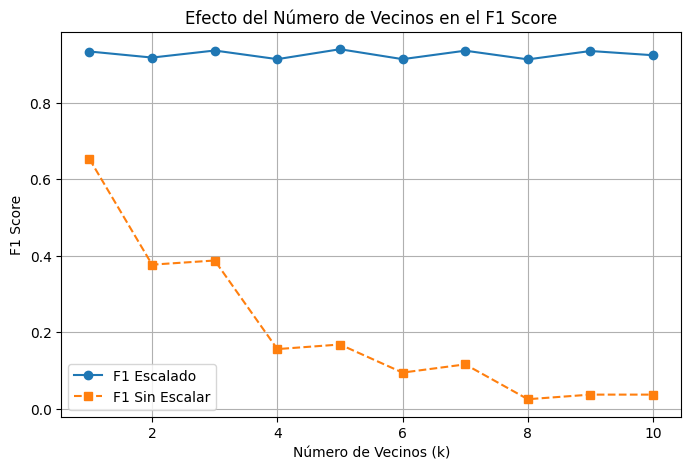

In [32]:
# Graficar los resultados
plt.figure(figsize=(8, 5))
plt.plot(k_values, f1_scaled_values, marker='o', linestyle='-', label='F1 Escalado')
plt.plot(k_values, f1_unscaled_values, marker='s', linestyle='--', label='F1 Sin Escalar')
plt.xlabel("Número de Vecinos (k)")
plt.ylabel("F1 Score")
plt.title("Efecto del Número de Vecinos en el F1 Score")
plt.legend()
plt.grid(True)
plt.show()

Conclusiones: Llama la atención lo importante que es escalar los datos para modelos knn. Esto se refleja en el F1, pues conforme más vecinos tiene, se desploma el f1, reflejando lo mucho que afecta. El mejor modelo es el que k = 5, pues el f1 escalado es de 0.939297. 

# Tarea 3. Regresión (con regresión lineal)

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ (X2.T @ y)

    def predict(self, X):
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = np.matmul(X2,self.weights) 
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [35]:
# Probando sin datos escalados

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [36]:
# Probando con datos escalados

scaler = sklearn.preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

lr_scaled = MyLinearRegression()

lr_scaled.fit(x_train_scaled,y_train)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(x_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

[ 0.14971429  0.30292778  0.0082117  -0.00258294 -0.01271039]
RMSE: 0.34
R2: 0.66


Conclusiones: 
1. Primero que nada, se observa que los pesos cambian en el modelo sin datos escalados respecto al de con datos escalados. Esto tiene lógica, pues cuando no se escala, variables como 'age' o 'income' que tienen valores más grandes, tienen a tener mayor importancia. En este caso, 'age' toma un mayor peso.
2. RMSE y R2 NO cambian, lo cual tiene lógica, pues al escalar el modelo, estamos cambiando el peso de los coeficientes, pero al final de cuentas la combinación de los coeficientes busca el mismo resultado, por lo que y_pred termina siendo prácticamente igual en este caso y no provoca que RMSE y R2 se ven afectadas, al menos con dos decimales son idénticos.

# Tarea 4. Ofuscar datos

In [37]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [38]:
df_pn

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0
...,...,...,...,...
4995,0,28,35700.0,2
4996,0,34,52400.0,1
4997,0,20,33900.0,2
4998,1,22,32700.0,3


In [39]:
X = df_pn.to_numpy()
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generar una matriz aleatoria $P$.

In [40]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [41]:
P_inv = np.linalg.inv(P)
print(P_inv)

[[ 0.41467992 -1.43783972  0.62798546  1.14001268]
 [-1.06101789  0.44219337  0.1329549   1.18425933]
 [ 1.42362442  1.60461607 -2.0553823  -1.53699695]
 [-0.11128575 -0.65813802  1.74995517 -0.11816316]]


P es invertible, si no lo fuera, no habría generado una matriz, hubiera aparecido un error. Después de corroborar que lo es, se puede multiplicar por la matriz X para ofuscar los datos.

In [42]:
# Ofuscar los datos de la matriz X
X_ofuscada = X @ P
X_ofuscada

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?

No, lo cual está perfecto, pues esa es precisamente la idea de ofuscar los datos, que no se puedan adivinar ni deducir a menos de que tengas la matriz P.

¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles

In [43]:
X_recuperada = X_ofuscada @ P_inv 
X_recuperada

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Muestra los tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [44]:
# Datos originales
print("Datos originales", X)

Datos originales [[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]


In [45]:
# Datos ofuscados
print("Datos ofuscados", X_ofuscada)

Datos ofuscados [[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]


In [46]:
# Datos recuperados
print("Datos recuperados",X_recuperada)

Datos recuperados [[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4.06000000e+04  1.00000000e+00]]


Algunos valores no son exactamente iguales a los de los datos originales, esto se debe a pequeños errores de redondeo durante las operaciones matriciales, tales como la multiplicación e inversión de estas.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

**Respuesta**

Después de la prueba analítica, vemos que el nuevo vector de pesos se relaciona con el original multiplicándolo por la inversa de P:
$$ Wp = P^{-1} w $$

Respecto a las predicciones, recordamos que las predicciones originales son:

$$ y = Xw $$

Con datos ofuscados:
$$ y = XP Wp $$

Sustituimos $$ Wp = P^{-1} w $$ 

Obtenemos: 
$$ y = XP P^{-1} w $$

Se cancelan debido a que la multiplicación entre la matriz P y su inversa dan como resultado la matriz de identidad, arrojando como resultado final:
$$ y = Xw $$

Con este resultado, podemos responder a la última pregunta y afirmar que las predicciones no cambian, y, por lo tanto, RECM y otras métricas no se ven afectadas

**Prueba analítica**

Tomamos el vector de pesos nuevo: 
$$ w_P = [(XP)^T XP]^{-1} (XP)^T y $$

Tomando en cuenta las propiedades de las matrices, sabemos que: 
$$ (XP)^T = P^T X^T $$

De esta forma, el elemento 
$$ [(XP)^T XP]^{-1} = (XP)^{-1} (X^T)^{-1} (P^T)^{-1} $$  

Sustituimos y obtenemos la siguiente fórmula:
$$ Wp = (XP)^{-1} (X^T)^{-1} (P^T)^{-1} (XP)^T y $$

Aplicamos la misma propiedad que antes, desarrollamos:
$$ Wp = (XP)^{-1} (X^T)^{-1} (P^T)^{-1} P^T X^T y $$

Recordando la propiedad:
$$ (P^T)^{-1} PT = I $$

Seguimos desarrollando y se cancelan:
$$ Wp = (XP)^{-1} (X^T)^{-1} X^T y $$

Aplicamos la propiedad del inverso en: $$ (XP)^{-1} $$

Obtenemos lo siguiente:
$$ Wp = P^{-1} X^{-1} (X^T)^{-1} X^T y $$

Finalmente, aplicamos la propiedad del inverso, pero ahora al revés:
$$ Wp = P^{-1} (X^T X)^{-1}  X^T y $$

Recordando el valor de w, sustituimos y finalmente nos queda lo siguiente:
$$ Wp = P^{-1} w $$

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

### SIN OFUSCAR

In [47]:
# Mostrando los resultados del DF original sin escalar
lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [48]:
# Mostrando los resultados del DF original escalados
scaler = sklearn.preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

lr_scaled = MyLinearRegression()

lr_scaled.fit(x_train_scaled,y_train)
print(lr_scaled.weights)

y_test_pred_scaled = lr_scaled.predict(x_test_scaled)
eval_regressor(y_test, y_test_pred_scaled)

[ 0.14971429  0.30292778  0.0082117  -0.00258294 -0.01271039]
RMSE: 0.34
R2: 0.66


### OFUSCADOS

In [49]:
# Creación de función para datos ofsucados

class RegresionLinealOfuscada:
    def __init__(self, seed=42):
        self.seed = seed
        self.P = None
        self.modelo = sklearn.linear_model.LinearRegression(fit_intercept=False)
    
    def invertible_matrix(self, n):
        rng = np.random.default_rng(self.seed)
        while True:
            P = rng.random((n, n))
            if np.linalg.cond(P) < 1/np.finfo(P.dtype).eps:
                return P

    def fit(self, X_train, y_train):
        n_features = X_train.shape[1]
        self.P = self.invertible_matrix(n_features)
        X_train_ofuscado = X_train @ self.P
        self.modelo.fit(X_train_ofuscado, y_train)
    
    def predict(self, X):
        X_ofuscado = X @ self.P
        return self.modelo.predict(X_ofuscado)
    
    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        rmse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)
        r2 = sklearn.metrics.r2_score(y_test, y_pred)
        return rmse, r2

In [50]:
# Mostrando los resultados del DF ofuscados sin escalar
X_train_ofuscada = np.c_[np.ones((X_train.shape[0], 1)), X_train]
X_test_ofuscada = np.c_[np.ones((X_test.shape[0], 1)), X_test]

lr_ofuscada = RegresionLinealOfuscada()

lr_ofuscada.fit(X_train_ofuscada, y_train)
print(lr_ofuscada.modelo.coef_)

y_test_pred_ofuscada = lr_ofuscada.predict(X_test_ofuscada)

rmse, r2 = lr_ofuscada.evaluate(X_test_ofuscada, y_test)
print("RMSE:", rmse)
print("R2:", r2)

[-1.32259697  0.31687813  0.65552966 -1.10490444  1.57904806]
RMSE: 0.34355650891364353
R2: 0.4305278542490233


In [51]:
# Mostrando los resultados del DF ofuscados y escalados
scaler_ofuscado = sklearn.preprocessing.StandardScaler()

x_train_scaled = scaler_ofuscado.fit_transform(X_train)
x_test_scaled = scaler_ofuscado.transform(X_test)

X_train_scaled_ofuscado = np.c_[np.ones((x_train_scaled.shape[0], 1)), x_train_scaled]
X_test_scaled_ofuscado = np.c_[np.ones((x_test_scaled.shape[0], 1)), x_test_scaled]

# Creamos y entrenamos el modelo
lr_ofuscada_scaled = RegresionLinealOfuscada()

lr_ofuscada_scaled.fit(X_train_scaled_ofuscado, y_train)

# Mostramos los coeficientes aprendidos
print(lr_ofuscada_scaled.modelo.coef_)

# Hacemos predicciones y evaluamos
y_test_pred_ofuscada_scaled = lr_ofuscada_scaled.predict(X_test_scaled_ofuscado)

rmse, r2 = lr_ofuscada_scaled.evaluate(X_test_scaled_ofuscado, y_test)

print("RMSE:", rmse)
print("R2:", r2)

[ 0.47482851  0.12931164 -0.23030351 -0.09028811 -0.14687235]
RMSE: 0.3435565089137969
R2: 0.4305278542485148


# Conclusiones

1. Como ya se había visto anteriormente, cuando el modelo no está ofuscado, coincide en RMSE y R2 tanto en el modelo con datos escalados como el que no, aunque no lo hace en los coeficientes, como es lógico.
2. Esto mismo coincide en la comparación de las respuestas cuando se ofuscan los datos: coinciden en el RMSE y el R2 con datos escalados como el que no los tiene escalados, pero los coeficientes cambian.
3. Vemos que el RMSE no cambia, es el mismo en los 4 modelos. Esto tiene sentido, pues en la respuesta analítica ya se había concluído que las predicciones no cambiaban, y recordando, el RMSE o RECM mide la distancia promedio entre las predicciones y los valores reales, por eso es prácticamente igual.
4. Finalmente, en cuanto al R2, este sí se ve afectado. Al parecer la ofuscación lo alteró. 